In [506]:
# ========================
# Inicio da pré-formatação
# ========================

# Gera uma lista de binários do tamanho da matriz
def generateStates(size):
    state = []
    sizeRoot = int(math.sqrt(size))
    for i in range(size):
        state.append(bin(i))
    for i in range(size):
        state[i] = state[i][1:]
        state[i] = state[i].replace('b', '')
        if len (state[i]) < sizeRoot: state[i] = (add0(sizeRoot - (len (state[i])))) + state[i]
    return state

# Marca os estados de acordo com a matriz
def markStates(state, matrix):
    size = maxIndex
    for i in range(size):
        if matrix[i] == 1: state[i] = '-' + state[i]
        else: state[i] = '+' + state[i]
    return state

# Concatena 0's a esquerda das strings
def add0(n):
    if n == 0:
        return ('')
    else:
        return ('0' + (add0(n-1)))

# Insere sinal positivo em um vetor inicializado
def allPositive(state, size):
    for i in range(size):
        state[i] = '+' + state[i]
    return state

# ========================
# Final da pré-formatação
# ========================

# Retorna quantos 1's há em uma string
def howMany1(string):
    count = 0
    for i in range(len(string)):
        if string[i] == '1': count = count +1
    return count

# "multiplica por -1" uma string binária (troca o sinal de um "pixel")
def singFlip(string):
    if string[0] == '-': return ('+' + string[1:])
    else: return ('-' + string[1:])

# Retorna os indexes dos '1' presentes da string binária
def whereIs1(string):
    locations = ''
    string = string[1:]
    for i in range(len(string)):
        if string[i] == '1': locations = locations + str(i)
    return locations

# singFlip em todos os elementos com '1' em uma posição especifica
def flipSingOn(state, location):
    for i in range(maxIndex):
        if state[i][location] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em duas posições especificas
def flipSingOn2(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em três posições especificas
def flipSingOn3(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    q2 = int(qubits[2]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1' and state[i][q2] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em quatro posições especificas
def flipSingOn4(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    q2 = int(qubits[2]) + 1
    q3 = int(qubits[3]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1' and state[i][q2] == '1' and state[i][q3] == '1':
            state[i] = singFlip(state[i])
    return state

# Gera circuito para bits com 1 |1⟩
def runTo1(statusVector, n):
    theQubits = whereIs1(goalVector[n])
    circuit.z(q[int(theQubits[0])]) # aplica z no qubit
    statusVector = flipSingOn(statusVector, int(theQubits[0])+1) # multiplica por -1 no vetor de status
    return statusVector

# Gera circuito para bits com 2 |1⟩
def runTo2(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    circuit.cz(q0, q1)
    statusVector = flipSingOn2(statusVector, theQubits)
    return statusVector

# Gera circuito para bits com 3 |1⟩
def runTo3(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    q2 = int(theQubits[2])
    global circuit
    circuit = ccz(circuit, q[q0], q[q1], q[q2], aux[0])
    statusVector = flipSingOn3(statusVector, theQubits)
    return statusVector

# Gera circuito para bits com 4 |1⟩
def runTo4(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    q2 = int(theQubits[2])
    q3 = int(theQubits[3])
    global circuit
    circuit = cccz(circuit, q[q0], q[q1], q[q2], q[q3], aux[0], aux[1])
    statusVector = flipSingOn4(statusVector, theQubits)
    return statusVector

# Gera circuito para operador U, baseado em sua matriz representativa
def generateU(matrix):
    maxIndex = len(matrix)
    goalVector = generateStates(maxIndex)
    goalVector = markStates(goalVector, matrix)
    statusVector = generateStates(maxIndex)
    statusVector = allPositive(statusVector, maxIndex)

    # Checando se objetivo[0] é -1
    if goalVector[0][0] == '-':
        for i in range(maxIndex):
            goalVector[i] = singFlip(goalVector[i])

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 1):
            statusVector = runTo1(statusVector, n)    

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 2):
            statusVector = runTo2(statusVector, n)

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 3):
            statusVector = runTo3(statusVector, n)

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 4):
            statusVector = runTo4(statusVector, n)

    circuit.barrier()

#=======================
# MULTI-CONTROLLED GATES
#=======================

def ccz(circ, q1, q2, q3, aux1):
# Apply Z-gate to a state controlled by 3 qubits
    circ.ccx(q1, q2, aux1)
    circ.cz(aux1, q3)
    # cleaning the aux bit
    circ.ccx(q1, q2, aux1)
    return circ

def cccz(circ, q1, q2, q3, q4, aux1, aux2):
# Apply Z-gate to a state controlled by 4 qubits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    circ.cz(aux2, q4)
    # cleaning the aux bits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    return circ

def ccccx(circ, q1, q2, q3, q4, q5, aux1, aux2):
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, q4, aux2)
    circ.ccx(aux2, aux1, q5)
    # cleaning the aux bits
    circ.ccx(q3, q4, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

In [507]:
import qiskit as qk
import math
nqubits = int(math.sqrt(maxIndex)) + 1
q = qk.QuantumRegister(nqubits)
c = qk.ClassicalRegister(1)
aux = qk.QuantumRegister(2) # Registrador auxiliar para o n-z-controlado
circuit = qk.QuantumCircuit(q, aux, c)

In [508]:
# Vetor de entrada Ui (estados a serem marcados)
inputV =  [1, 1, 0, 0,
           0, 0, 0, 0,
           0, 0, 0, 0,
           0, 0, 0, 0]

# Vetor de pesos Uw (estados a serem marcados)
weightsV =  [0, 0, 1, 1,
             1, 0, 0, 0,
             0, 0, 0, 0,
             0, 0, 0, 0]

In [509]:
for i in range(4):
    circuit.h(q[i])

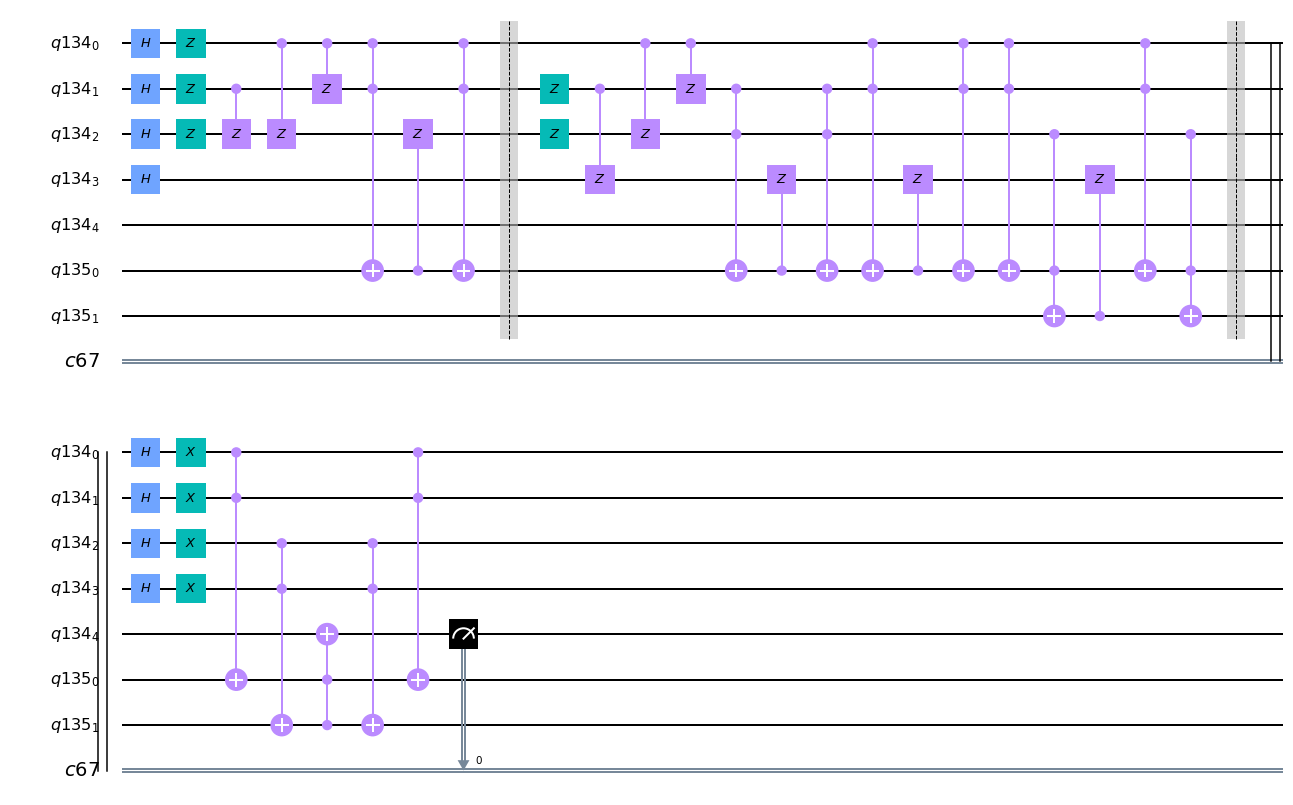

In [510]:
generateU(inputV)
generateU(weightsV)

for i in range(4):
    circuit.h(q[i])
    circuit.x(q[i])

circuit = ccccx(circuit, q[0], q[1], q[2], q[3], q[4], aux[0], aux[1])
circuit.measure(q[4], c[0])
    
circuit.draw(output='mpl')